In [234]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving 1.jpg to 1.jpg
Saving 6.jpg to 6.jpg
Saving 7.jpg to 7.jpg
Saving 8.jpg to 8.jpg
User uploaded file "1.jpg" with length 44885 bytes
User uploaded file "6.jpg" with length 45113 bytes
User uploaded file "7.jpg" with length 50439 bytes
User uploaded file "8.jpg" with length 47582 bytes


In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [0]:
def disp(img) :
  plt.imshow(img, cmap = 'gray')

In [0]:
filename = "bike (1).jpg"
img = cv2.imread(filename)

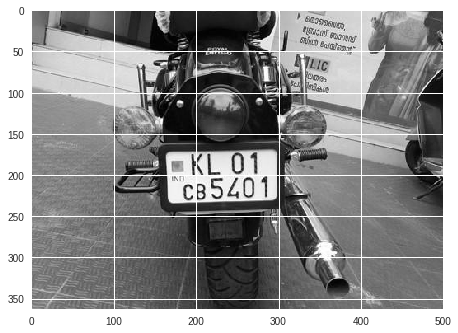

In [284]:
grey_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
disp(grey_img)

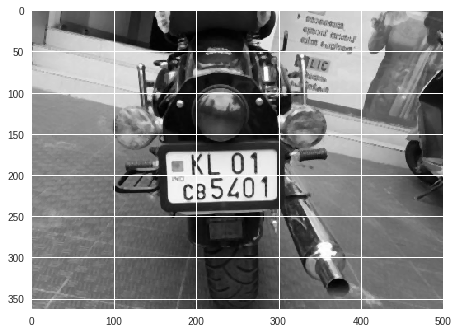

In [285]:
median_img = cv2.medianBlur(grey_img, 3)
disp(median_img)

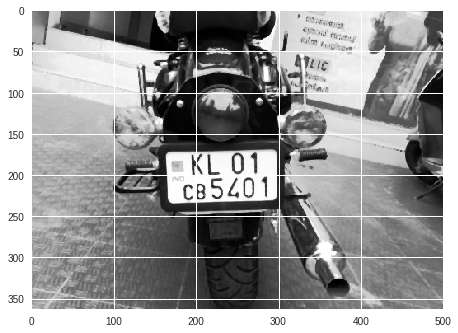

In [286]:
equ_img = cv2.equalizeHist(median_img)
disp(equ_img)

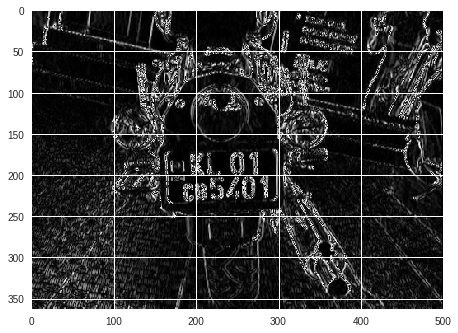

In [287]:
sobelx64f = cv2.Sobel(equ_img,cv2.CV_64F, 1, 0, ksize=3)
abs_sobel64f = np.absolute(sobelx64f)
sobel_8u = np.uint8(abs_sobel64f)
disp(sobel_8u)

(363, 500)


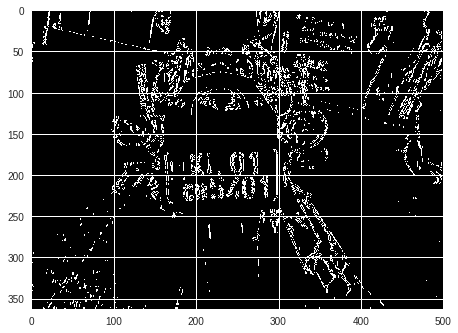

In [288]:
mu_grad = int(np.mean(sobel_8u))
print(sobel_8u.shape)
ret, thresh_img = cv2.threshold(sobel_8u, 127, 255, cv2.THRESH_BINARY)
disp(thresh_img)

In [289]:
Tmin = 5
Hmin = 10
Vxmax = 40
height = thresh_img.shape[0]
width = thresh_img.shape[1]

print(height, width)

363 500


(363,)
[[0, 0, 499, 234], [0, 236, 499, 345], [0, 347, 499, 349]]


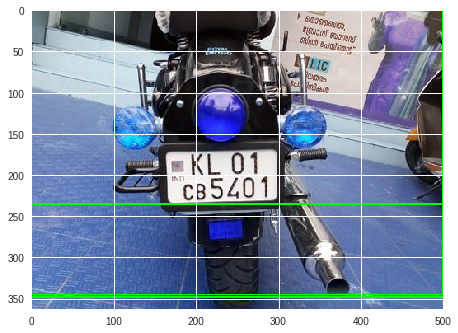

In [290]:
# first stage

edge_pixel = np.array([np.nonzero(thresh_img[i])[0] for i in range(height)])

# edge_pixel = []
# for i in range(height) :
#   edge_pixel.append([])
#   for j in range(width) :
#     if thresh_img[i][j] : 
#       edge_pixel[i].append(j)
      
edge_pixel = np.array(edge_pixel)
print(edge_pixel.shape)

mean = height * [0]
variance = height * [0]

for i in range(len(edge_pixel)) :
   if len(edge_pixel[i]) > Tmin :
      mean[i] = np.mean(edge_pixel[i])
      variance[i] = np.var(edge_pixel[i])
      
bands = []
band_top = 0
band_bottom = 0
in_band = False

for i in range(height) :
  if variance[i] > Vxmax :
    if not in_band :
      band_top = i
      in_band = True
    band_bottom = i
  elif in_band :
    bands.append([0, band_top, width - 1, band_bottom])
    in_band = False

print(bands)    

bands_img = img.copy()

for band in bands :
  bands_img = cv2.rectangle(bands_img, (band[0], band[1]), (band[2], band[3]), (0, 255, 0), 1)
disp(bands_img)

[[32, 0, 499, 234], [0, 236, 499, 345], [0, 347, 279, 349]]


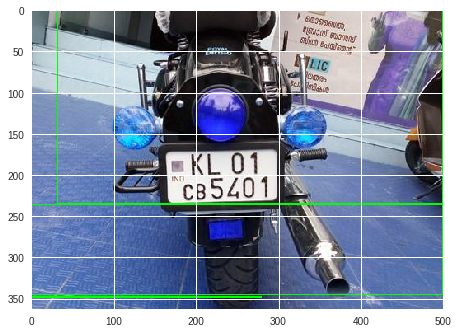

In [291]:
# second stage

for i, band in enumerate(bands) :
  mean_roi = mean[band[1] : band[3] + 1]
  var_roi = variance[band[1] : band[3] + 1]
  mu_min = min(mean_roi)
  mu_max = max(mean_roi)
  v_max = max(var_roi)
  
  band[0] = max(0, int(np.floor(mu_min - np.sqrt(v_max))))
  band[2] = min(width - 1, int(np.ceil(mu_max + np.sqrt(v_max))))
  
  bands[i] = band
  
print(bands)

bands_img = img.copy()

for band in bands :
  bands_img = cv2.rectangle(bands_img, (band[0], band[1]), (band[2], band[3]), (0, 255, 0), 1)
disp(bands_img)  

(235, 433)
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0   0 ... 255 255   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
(110, 302)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(3, 280)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0 255   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  255 255   0 255   0   0   0   0   0   0   0 255 255   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

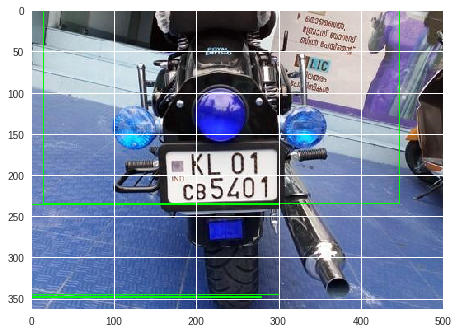

In [296]:
# third stage

for band in bands :
  box = thresh_img[band[1] : band[3] + 1]
  box = [b[band[0] : band[2] + 1] for b in box]
  box = np.array(box)
  print(box.shape)
#   vert_edge_len = np.count_nonzero(box, axis = 0)
  
#   for i in range(len(vert_edge_len)) :
#     if vert_edge_len[i] >= Hmin :
#       band[0] = i
#       break
#   for i in range(len(vert_edge_len) - 1, 0, -1) :
#     if vert_edge_len[i] >= Hmin :
#       band[2] = i
#       break
print(bands)
bands_img = img.copy()
for band in bands :
  bands_img = cv2.rectangle(bands_img, (band[0], band[1]), (band[2], band[3]), (0, 255, 0), 1)
disp(bands_img)